# Sound speed as a source of modified gravity

In Horndeski theory, the dark energy sound speed is given by the basis functions $\alpha_M$, $\alpha_B$, $\alpha_K$ and $\alpha_T$. The term $\alpha_T$ is assumed to be zero. We can further assume $M_* = 1$, implying $\alpha_M = 0$. We obtain:

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(\frac{3}{2}(1 + w_t) + \frac{\alpha_B}{2} \right) + 3(1 + w_t).
\end{equation}

In terms of the $\mu-\Sigma$ parametrization, we find

\begin{equation}
    \mu = \Sigma = 1 + \frac{\alpha_B^2}{2c_s^2\left(\alpha_K + \frac{3}{2}\alpha_B^2\right)}
\end{equation}

Let's explore the solutions for $\alpha_B$ and $\mu$ assuming a cubic galileon parametrization

\begin{equation}
    \alpha_K = c_2\frac{H_0^4}{H^4}\Omega_\mathrm{DE} + 6\alpha_B
\end{equation}

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from engine import *

## One Cosmology

Text(0, 0.5, '$\\mu$')

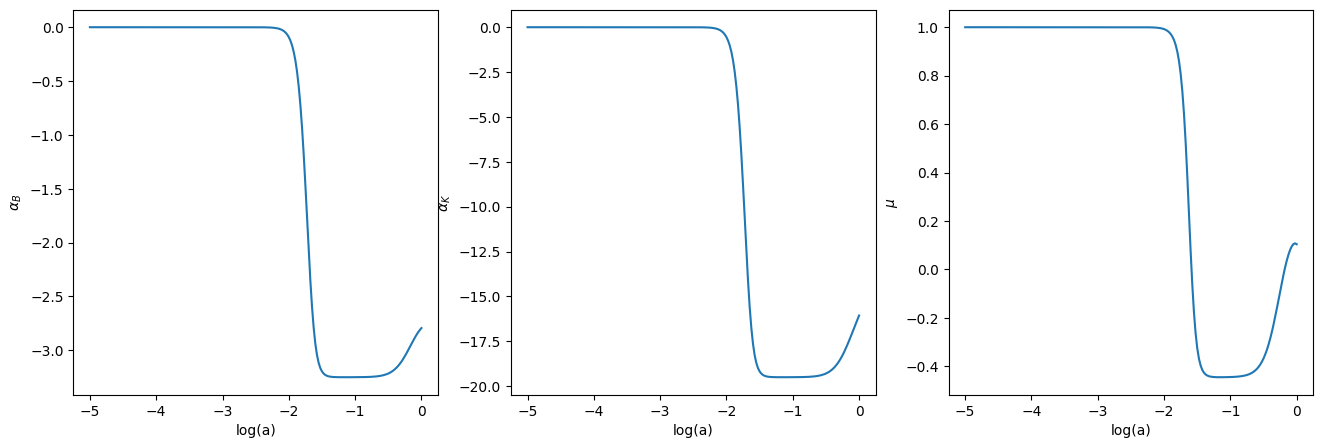

In [19]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.838,
    "wa": -0.62,
    "cs2": 1,
    "alpha_K_0": 1,
    # "alpha_B_init": 0
}

log_a, alpha_B, alpha_K, mu = solve_alpha_B(aktype=alphaKtype.CUGAL, **reference_cosmo)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(log_a, alpha_B)
axs[0].set_xlabel("log(a)")
axs[0].set_ylabel("$\\alpha_B$")
axs[1].plot(log_a, alpha_K)
axs[1].set_xlabel("log(a)")
axs[1].set_ylabel("$\\alpha_K$")
axs[2].plot(log_a, mu)
axs[2].set_xlabel("log(a)")
axs[2].set_ylabel("$\\mu$")

## Sampling across parameter space

### 1. Star Sampling

/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:92: RuntimeWarning: invalid value encountered in scalar divide
  mu[0]      = 1 + alpha_B[0]**2/2/(alpha_K[0] + 1.5*alpha_B[0]**2)/cs2
/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:106: RuntimeWarning: invalid value encountered in scalar divide
  mu[i+1]      = 1 + alpha_B[i+1]**2/2/(alpha_K[i+1] + 1.5*alpha_B[i+1]**2)/cs2
/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  mu[i+1]      = 1 + alpha_B[i+1]**2/2/(alpha_K[i+1] + 1.5*alpha_B[i+1]**2)/cs2


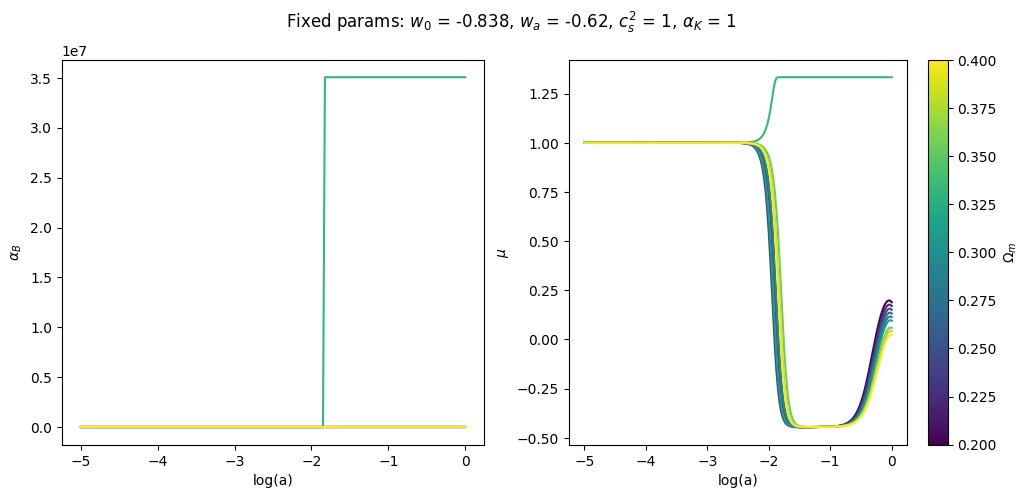

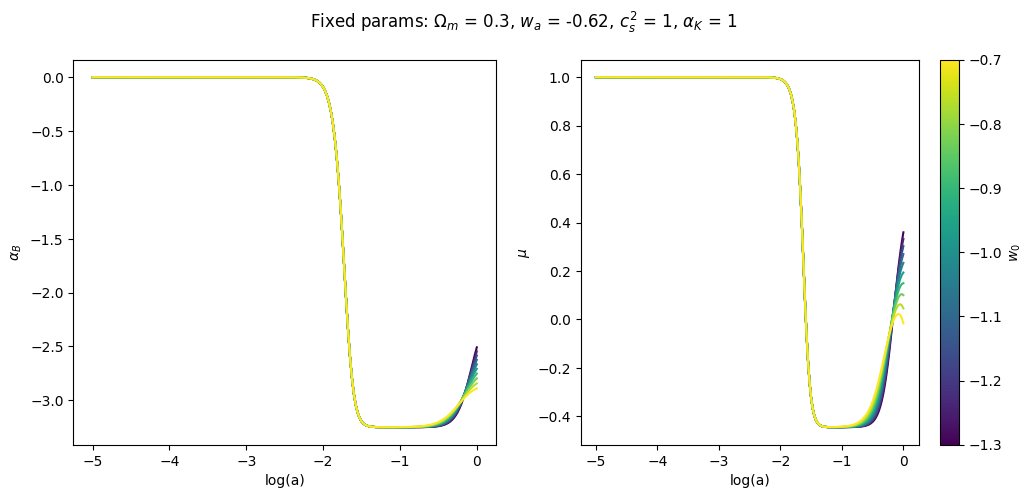

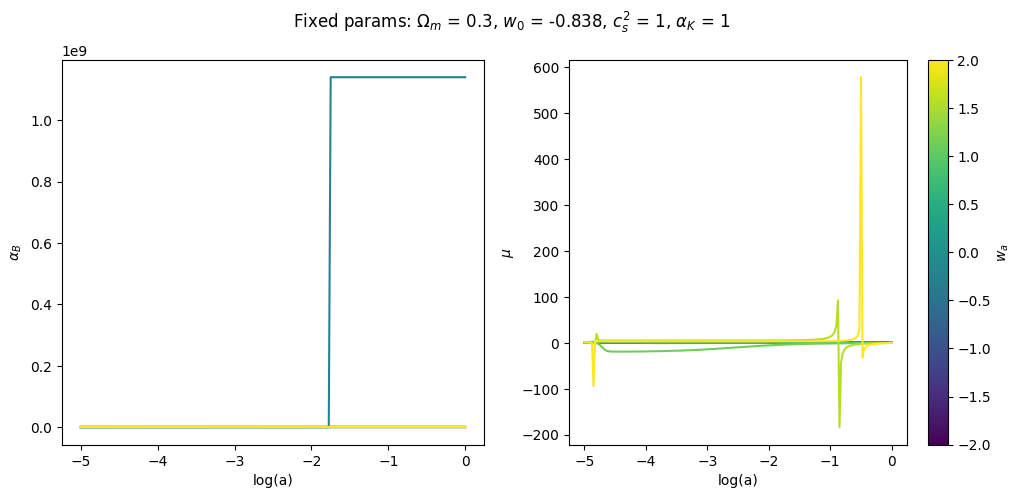

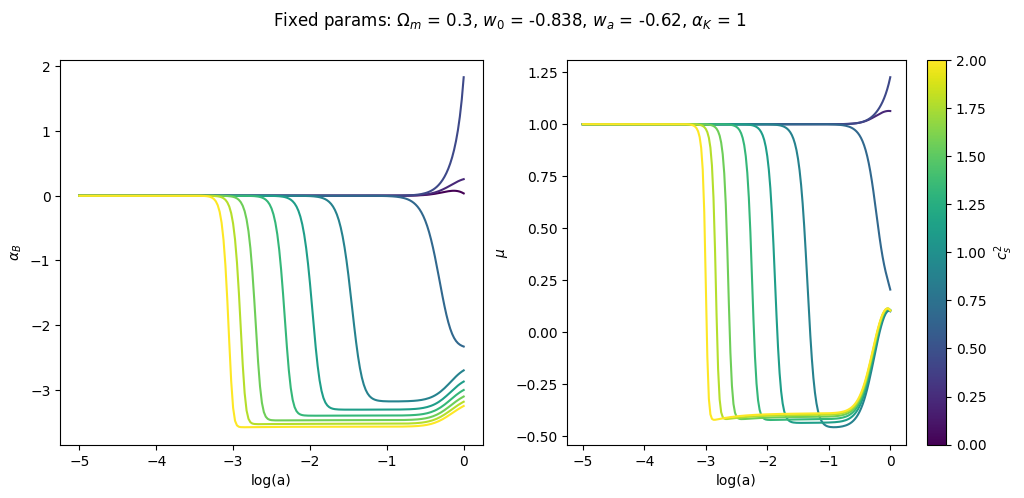

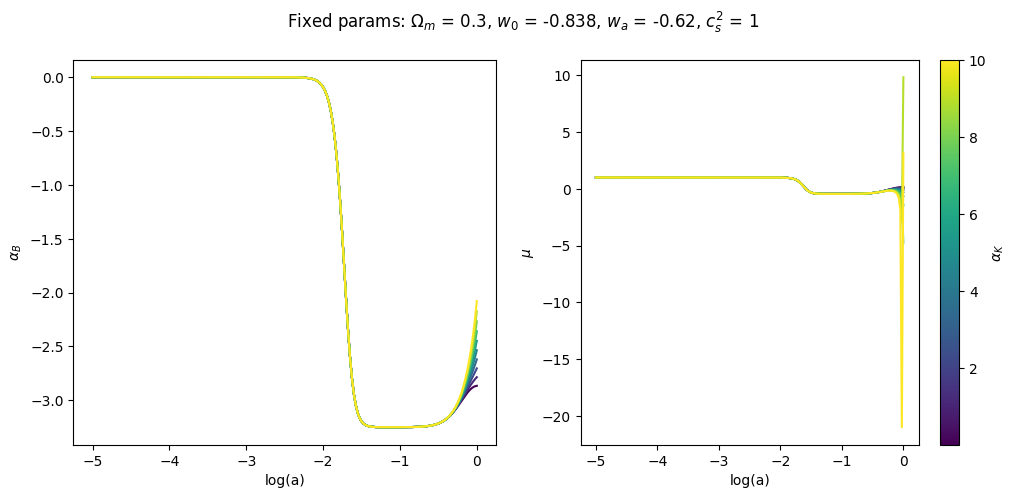

In [9]:
grids = {
    "omega_m": np.linspace(0.2, 0.4, 10),
    "w0"     : np.linspace(-1.3, -0.7, 10),
    "wa"     : np.linspace(-2, 2, 10),
    "cs2"    : np.linspace(0, 2, 10),
    "alpha_K_0": np.linspace(1e-3, 10, 10),
    # "alpha_B_init": np.linspace(-1, 1, 10), # NOTE: solution converges to attractor quickly
}

param_name_latex = {
    "omega_m": "$\\Omega_m$",
    "w0"     : "$w_0$",
    "wa"     : "$w_a$",
    "cs2"    : "$c_s^2$",
    "alpha_K_0": "$\\alpha_K$",
}

cmap = plt.get_cmap('viridis')

for param_name in grids.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    params = reference_cosmo.copy()
    norm = mpl.colors.Normalize(vmin=grids[param_name][0], vmax=grids[param_name][-1])
    for param_value in grids[param_name]:
        params[param_name] = param_value
        loga, alpha_B, alpha_K, mu = solve_alpha_B(aktype=alphaKtype.CUGAL, **params)
        color = cmap(norm(param_value))
        axs[0].plot(loga, alpha_B, color=color)
        axs[1].plot(loga, mu, color=color)
    for ax in axs:
        ax.set_xlabel("log(a)")
    axs[0].set_ylabel("$\\alpha_B$")
    axs[1].set_ylabel("$\\mu$")
    
    del params[param_name]
    title = ", ".join([" = ".join((param_name_latex[name], f"{value}")) for (name, value) in params.items()])
    fig.suptitle(f"Fixed params: {title}")

    # Create a ScalarMappable for the colorbar (no data required)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # for colorbar compatibility

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(param_name_latex[param_name])
    plt.savefig(f"plots/cugal/{param_name}_scan.pdf")

### 2. Random Sampling

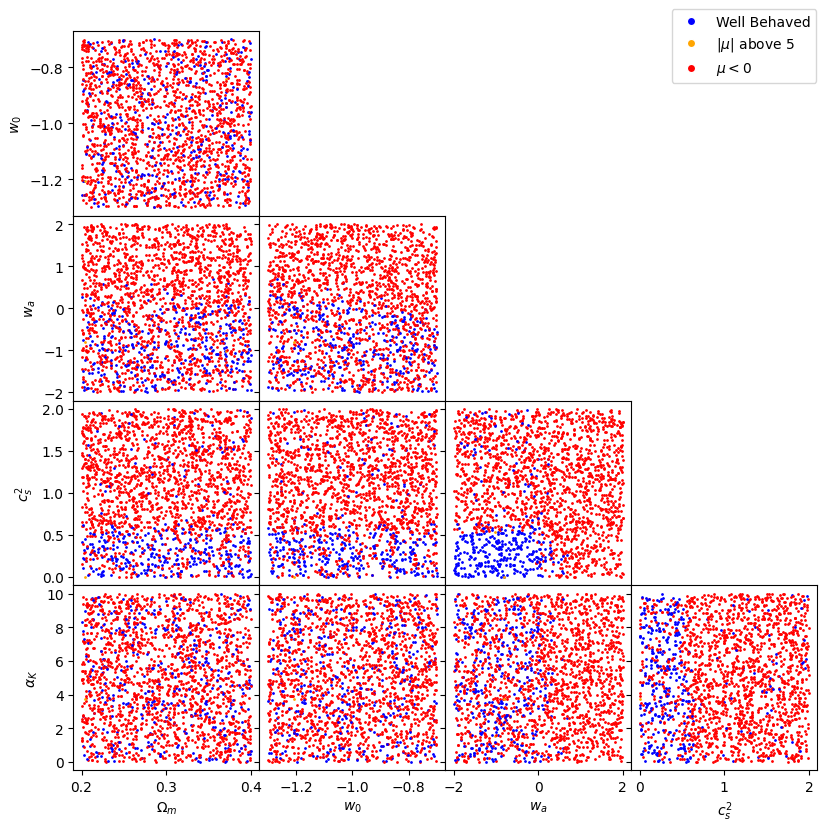

In [43]:
priors = {
    "omega_m"  : [0.2, 0.4],
    "w0"       : [-1.3, -0.7],
    "wa"       : [-2, 2],
    "cs2"      : [0, 2],
    "alpha_K_0": [0, 10],
}
priors_keys  = list(priors.keys())
priors_array = np.array(list(priors.values()))
low = priors_array[:, 0]
high = priors_array[:, 1]

alpha_B_threshold = 100
mu_threshold = 5

# Parallelizing loop for testing cases
from concurrent.futures import ProcessPoolExecutor
num_samples = 2_000
samples_params = np.random.rand(num_samples, len(priors)) * (high - low)[None, :] + low[None, :]
samples_params[0] = np.array(list(reference_cosmo.values()))
samples = []
def worker(sample):
    params_dict = dict(zip(priors_keys, sample))
    _, _, _, mu = solve_alpha_B(aktype=alphaKtype.CUGAL, **params_dict)
    if np.any(mu < 0): color = "red"
    elif np.any(np.abs(mu) > mu_threshold): color = "orange"
    else: color = "blue"
    return sample, color

with ProcessPoolExecutor(max_workers=None) as exe:
    for params_row, color in exe.map(worker, samples_params):
        samples.append((params_row, color))


fig, axs = plt.subplots(len(priors), len(priors), figsize=(12, 12), gridspec_kw={"hspace": 0, "wspace": 0})
for row in range(len(priors)):
    for col in range(len(priors)):
        ax = axs[row, col]
        if row == len(priors)-1: ax.set_xlabel(list(param_name_latex.values())[col])
        else: ax.set_xticklabels([])
        if col == 0:             ax.set_ylabel(list(param_name_latex.values())[row])
        else: ax.set_yticklabels([])
            
        if col >= row: ax.remove()
        for sample in samples:
            point, color = sample
            ax.scatter(point[col], point[row], color=color, s=1)

blue_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="blue", label="Well Behaved", )
orange_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="orange", label=f"$|\\mu|$ above {mu_threshold}", )
red_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="red", label=f"$\\mu < 0$", )
fig.legend(handles=[blue_circle, orange_circle, red_circle], bbox_to_anchor=(0.75, 0.75))

plt.savefig("plots/cugal/alpha_B_samples.pdf", bbox_inches="tight")

In [41]:
samples

[(array([ 0.3  , -0.838, -0.62 ,  1.   ,  1.   ]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.float64(1.0))),
 (array([ 0.20549388, -1.17124503,  0.83594374,  1.87762972,  4.23248439]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.float64(1.0))),
 (array([ 0.21649545, -0.9769695 , -0.67664836,  1.98439568,  6.44551835]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.float64(1.0))),
 (array([ 0.39247453, -0.98402234,  0.04780165,  0.35615726,  3.04062328]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.float64(1.0))),
 (array([ 0.34012899, -0.77417027, -0.97615133,  1.92688381,  9.26607743]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.float64(1.0))),
 (array([ 0.3396345 , -1.21210729,  0.97591136,  1.56003203,  2.48411683]),
  (np.float64(0.993248),
   np.float64(0.906157),
   np.float64(0.143936),
   np.flo